# Titanic Dataset

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import chi2, f_classif
from sklearn.preprocessing import LabelEncoder, MinMaxScaler



In [39]:
df = pd.read_csv("/kaggle/input/titanic1/titanic_train.csv")

df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [40]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [41]:
# Drop the columns with null values>30%

df.dropna(axis = 1,thresh= 0.7*len(df),inplace = True)

# Filling the nulll values(numeric column) with median

numerical_cols = df.select_dtypes(include = ['int64','float64']).columns
categorical_cols = df.select_dtypes(include = ['int64','float64']).columns

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [42]:
X = df.drop("Survived", axis=1)
y = df["Survived"]

print("Train shape:", X.shape)

Train shape: (891, 10)


In [43]:
import pandas as pd

# Identify categorical columns
cat_cols = X.select_dtypes(include=['object', 'category']).columns

# Apply One-Hot Encoding to all categorical columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)
X = X_encoded.copy()

In [44]:
constant_features = [col for col in X.columns if X[col].nunique() == 1]

print(constant_features)


[]


In [45]:
# 4. Quasi-constant features (based on threshold)
quasi_constant_features = []
threshold = 0.99

for col in X.columns:
    freq = X[col].value_counts(normalize=True).values[0]
    if freq >= threshold:
        quasi_constant_features.append(col)

print("Quasi-constant features:", quasi_constant_features)

X.drop(columns=quasi_constant_features, inplace=True)

Quasi-constant features: ['Name_Abbott, Mr. Rossmore Edward', 'Name_Abbott, Mrs. Stanton (Rosa Hunt)', 'Name_Abelson, Mr. Samuel', 'Name_Abelson, Mrs. Samuel (Hannah Wizosky)', 'Name_Adahl, Mr. Mauritz Nils Martin', 'Name_Adams, Mr. John', 'Name_Ahlin, Mrs. Johan (Johanna Persdotter Larsson)', 'Name_Aks, Mrs. Sam (Leah Rosen)', 'Name_Albimona, Mr. Nassef Cassem', 'Name_Alexander, Mr. William', 'Name_Alhomaki, Mr. Ilmari Rudolf', 'Name_Ali, Mr. Ahmed', 'Name_Ali, Mr. William', 'Name_Allen, Miss. Elisabeth Walton', 'Name_Allen, Mr. William Henry', 'Name_Allison, Master. Hudson Trevor', 'Name_Allison, Miss. Helen Loraine', 'Name_Allison, Mrs. Hudson J C (Bessie Waldo Daniels)', 'Name_Allum, Mr. Owen George', 'Name_Andersen-Jensen, Miss. Carla Christine Nielsine', 'Name_Anderson, Mr. Harry', 'Name_Andersson, Master. Sigvard Harald Elias', 'Name_Andersson, Miss. Ebba Iris Alfrida', 'Name_Andersson, Miss. Ellis Anna Maria', 'Name_Andersson, Miss. Erna Alexandra', 'Name_Andersson, Miss. Ingeb

In [46]:
duplicated_features = []
cols = X.columns

for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        if X[cols[i]].equals(X[cols[j]]):
            duplicated_features.append(cols[j])

print(duplicated_features)

[]


In [47]:
corr_matrix = X.corr()
corr_threshold = 0.98
corr_pairs = set()

# Find highly correlated features
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            corr_pairs.add(corr_matrix.columns[i])

print("Highly Correlated Features:", corr_pairs)

Highly Correlated Features: set()


[]

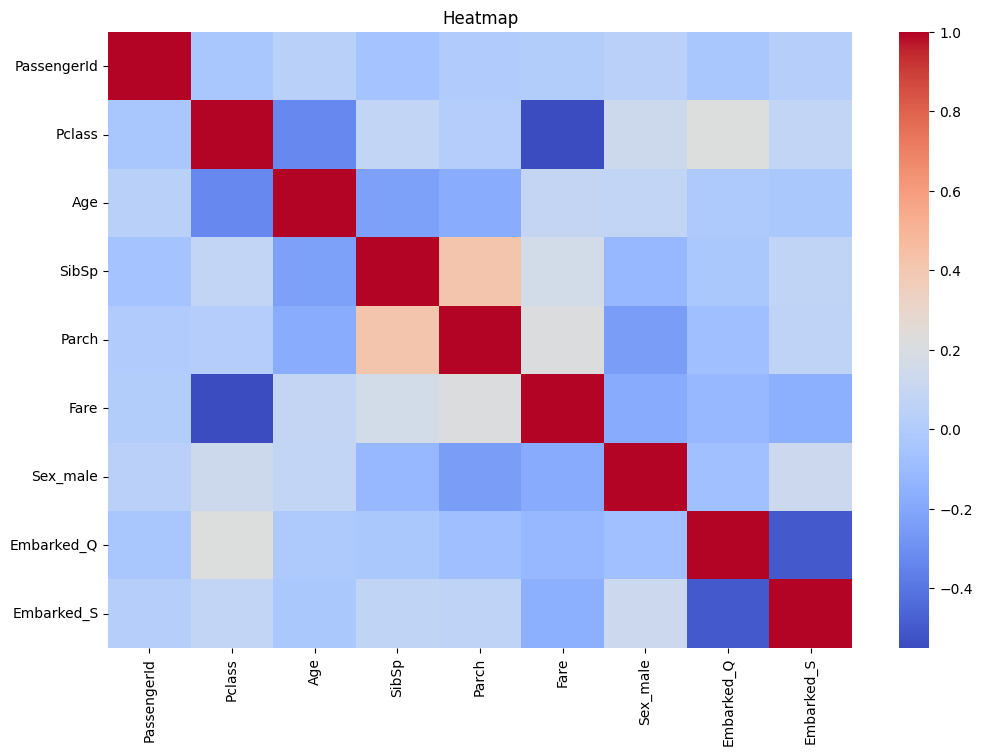

In [48]:
plt.figure(figsize = (12,8))
sns.heatmap(corr_matrix,annot=False,cmap = "coolwarm")
plt.title("Heatmap")
plt.plot()

In [49]:
from sklearn.feature_selection import mutual_info_regression
import pandas as pd

# Compute MI scores
mi_scores = mutual_info_regression(X, y, discrete_features=False)

# Create DataFrame of results
mi_df = pd.DataFrame({
    "Features": X.columns,
    "MI Score": mi_scores
}).sort_values(by="MI Score", ascending=False)

# Select features with MI score < 0.01
low_imp = mi_df[mi_df["MI Score"] < 0.01]["Features"].tolist()

print("Low Importance Features:", low_imp)

# Drop low importance features
X = X.drop(columns=low_imp)

Low Importance Features: ['Embarked_Q']


In [50]:
from sklearn.feature_selection import SelectKBest, chi2
import pandas as pd

# 1. Apply Chi-Square
selector = SelectKBest(score_func=chi2, k='all')
X_new = selector.fit_transform(X, y)

# 2. Get feature scores and p-values
feature_scores = selector.scores_
feature_pvalues = selector.pvalues_

# 3. Combine for analysis
feature_info = pd.DataFrame({
    'Feature': X.columns,
    'Chi2 Score': feature_scores,
    'p-value': feature_pvalues
}).sort_values(by='Chi2 Score', ascending=False)

print("Top Features based on Chi-Square:\n", feature_info)

# 4. Identify features to drop (p-value > 0.05)
features_to_drop = feature_info[feature_info['p-value'] > 0.05]['Feature'].tolist()

# 5. Drop them from X
X = X.drop(columns=features_to_drop)

print(f"\nDropped {len(features_to_drop)} features due to high p-value.")


Top Features based on Chi-Square:
        Feature   Chi2 Score       p-value
5         Fare  4518.319091  0.000000e+00
6     Sex_male    92.702447  6.077838e-22
1       Pclass    30.873699  2.753786e-08
2          Age    24.687926  6.740514e-07
4        Parch    10.097499  1.484707e-03
7   Embarked_S     5.984840  1.442935e-02
0  PassengerId     3.312934  6.873667e-02
3        SibSp     2.581865  1.080942e-01

Dropped 2 features due to high p-value.


In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_classif
import pandas as pd

# Scale features (recommended for ANOVA stability)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Apply ANOVA F-test for classification
f_scores, p_values_anova = f_classif(X_scaled, y)

anova_df = pd.DataFrame({
    'Feature': X.columns,
    'F_Score': f_scores,
    'P_Value': p_values_anova
}).sort_values(by='F_Score', ascending=False)

print("\nANOVA Test Results:")
print(anova_df)

# Drop features with p-value > 0.05
features_to_drop = anova_df[anova_df['P_Value'] > 0.05]['Feature'].tolist()
X = X.drop(columns=features_to_drop)

print(f"\nDropped {len(features_to_drop)} features due to high p-value.")



ANOVA Test Results:
      Feature     F_Score       P_Value
4    Sex_male  372.405724  1.406066e-69
0      Pclass  115.031272  2.537047e-25
3        Fare   63.030764  6.120189e-15
5  Embarked_S   22.075469  3.036111e-06
2       Parch    5.963464  1.479925e-02
1         Age    4.353516  3.721708e-02

Dropped 0 features due to high p-value.


export the X,y 

In [53]:
# If y is a Series
df_final = X.copy()
df_final['target'] = y
df_final.to_csv('titanic_fs_dataset.csv', index=False)

print(df_final)

     Pclass        Age  Parch     Fare  Sex_male  Embarked_S  target
0         3  22.000000      0   7.2500      True        True       0
1         1  38.000000      0  71.2833     False       False       1
2         3  26.000000      0   7.9250     False        True       1
3         1  35.000000      0  53.1000     False        True       1
4         3  35.000000      0   8.0500      True        True       0
..      ...        ...    ...      ...       ...         ...     ...
886       2  27.000000      0  13.0000      True        True       0
887       1  19.000000      0  30.0000     False        True       1
888       3  29.699118      2  23.4500     False        True       0
889       1  26.000000      0  30.0000      True       False       1
890       3  32.000000      0   7.7500      True       False       0

[891 rows x 7 columns]
